# HSCT survival: Weibull accelerated failure model

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import WeibullAFTFitter
from sklearn.model_selection import train_test_split

import configuration as config
import functions.helper as helper_funcs

pd.set_option('display.max_rows', 500)

feature_pval_cutoff=0.001
dataset='Nominal one-hot/ordinal encoded, NANs imputed'

# Dataset definition file
datasets_file=f'{config.PROCESSED_DATA}/02.1-dataset_definitions.pkl'

# Feature type definitions file
feature_types_dict_file=f'{config.PROCESSED_DATA}/01.1-feature_type_dict.pkl'

# Output file
survival_file=f'{config.PROCESSED_DATA}/02.2-weibullAFT_survival.pkl'


## 1. Load data

In [2]:
# Load dataset definitions
with open(datasets_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

print('Datasets:\n')
for description, filepath in datasets.items():
    print(f' {description}')

# Load feature definitions
with open(feature_types_dict_file, 'rb') as input_file:
    feature_types=pickle.load(input_file)

print('\nFeature types:\n')
for feature_type, features in feature_types.items():
    print(f' {feature_type}: {features}\n')

# Load one of the datasets
with open(datasets['Nominal one-hot/ordinal encoded, NANs encoded'], 'rb') as input_file:
    data_dict=pickle.load(input_file)

print('Data dictionary contains:\n')
for key, value in data_dict.items():
    print(f' {key}: {type(value)}')

# Combine features and labels
training_df=data_dict['Training features']
training_df[['efs', 'efs_time']]=data_dict['Training labels']

testing_df=data_dict['Testing features']
testing_df[['efs', 'efs_time']]=data_dict['Testing labels']

Datasets:

 Nominal one-hot/ordinal encoded, NANs encoded
 Nominal one-hot/ordinal encoded, NANs imputed
 All ordinal encoded, NAN encoded
 All ordinal encoded, NAN imputed
 Binary target encoded
 Continuous target encoded

Feature types:

 Interval: ['donor_age', 'age_at_hct']

 Ordinal: ['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'dri_score', 'cyto_score', 'cmv_status', 'cyto_score_detail']

 Nominal: ['psych_disturb', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'tce_imm_match', 'rituximab', 'prod_type', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 't

## 2. Weibull AFT model

### 2.1. Naive model

In [3]:
waft_model=WeibullAFTFitter()
waft_model.fit(training_df, duration_col='efs_time', event_col='efs')

<lifelines.WeibullAFTFitter: fitted with 20160 total observations, 9292 right-censored observations>

In [4]:
waft_model.print_summary()

<lifelines.WeibullAFTFitter: fitted with 20160 total observations, 9292 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
   number of observations = 20160
number of events observed = 10868
           log-likelihood = -47694.50
         time fit was run = 2025-02-26 04:13:31 UTC

---
                                                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                                             
lambda_ age_at_hct                                           -0.00      1.00      0.00           -0.01           -0.00                0.99                1.00
        arrhythmia_Yes                                       -0.07      0.93      0.06           -0.19            0.06                0.83                1.06
        arrhythmia_missing                                   -0.11      0.90      0.08           -0.26            0.05                0.77                1.05
        cardiac_Yes                                          -0.59      0.56      0.05           -0.69           -0.48                0.50                0.62
        cardiac_missing                                      -0.00      1.00      0.07           -0.14            0.14                0.87                1.15
        cmv_status                                           -0.02      0.98      0.02           -0.06            0.02                0.94                1.02
        comorbidity_score                                    -0.05      0.95      0.01           -0.06           -0.04                0.94                0.96
        conditioning_intensity_NMA                            0.07      1.07      0.05           -0.03            0.16                0.98                1.17
        conditioning_intensity_None                          -0.10      0.90      0.26           -0.61            0.40                0.54                1.50
        conditioning_intensity_RIC                           -0.39      0.68      0.04           -0.46           -0.31                0.63                0.73
        conditioning_intensity_missing                        0.72      2.04      0.07            0.59            0.84                1.80                2.32
        cyto_score                                           -0.05      0.95      0.01           -0.07           -0.02                0.93                0.98
        cyto_score_detail                                    -0.02      0.98      0.02           -0.06            0.01                0.94                1.01
        diabetes_Yes                                         -0.22      0.80      0.04           -0.29           -0.15                0.74                0.86
        diabetes_missing                                      0.14      1.15      0.08           -0.01            0.29                0.99                1.34
        donor_age                                            -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
        donor_related_No                                     -0.27      0.76      0.14           -0.54           -0.00                0.58                1.00
        donor_related_Yes                                    -0.10      0.91      0.14           -0.37            0.17                0.69                1.18
        donor_related_missing                                 0.14      1.16      0.24           -0.32            0.61                0.73                1.83
        dri_score                                            -0.06      0.94      0.01           -0.08           -0.04                0.93                0.96
        ethnicity_-His+Lat                                    0.08      1.08      0.05           -0.01            0.17                0.99                1.18
      

### 2.2. Feature p-values

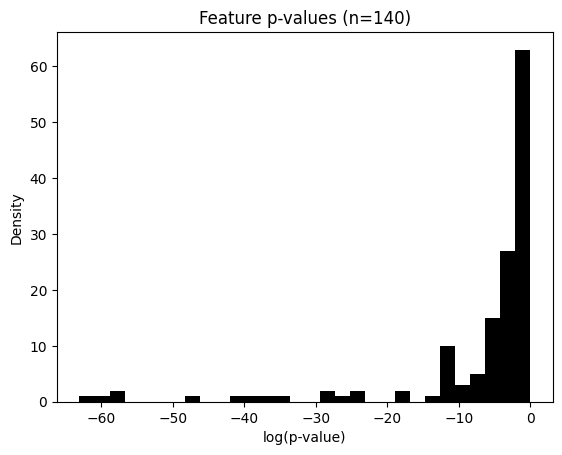

Significant features at alpha = 0.05: 63
Significant features at alpha = 0.001: 35


In [5]:
feature_pvals=waft_model.summary['p']
feature_pvals=feature_pvals.droplevel(0)
feature_pvals.drop('Intercept', axis=0, inplace=True)

plt.title(f'Feature p-values (n={len(feature_pvals)})')
plt.hist(np.log(feature_pvals), color='black', bins=30)
plt.xlabel('log(p-value)')
plt.ylabel('Density')
plt.show()

significant_features=feature_pvals[feature_pvals < 0.05]
print(f'Significant features at alpha = 0.05: {len(significant_features)}')

significant_features=feature_pvals[feature_pvals < 0.001]
print(f'Significant features at alpha = 0.001: {len(significant_features)}')

### 2.3. Feature selection

In [6]:
training_significant_features_df=training_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()
testing_significant_features_df=testing_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()

training_significant_features_df['efs']=training_df['efs']
training_significant_features_df['efs_time']=training_df['efs_time']
testing_significant_features_df['efs']=testing_df['efs']
testing_significant_features_df['efs_time']=testing_df['efs_time']

### 2.4. Re-train model

In [7]:
waft_model=WeibullAFTFitter()
waft_model.fit(training_significant_features_df, duration_col='efs_time', event_col='efs')
waft_model.print_summary()

<lifelines.WeibullAFTFitter: fitted with 20160 total observations, 9292 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
   number of observations = 20160
number of events observed = 10868
           log-likelihood = -47948.68
         time fit was run = 2025-02-26 04:13:50 UTC

---
                                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                             
lambda_ age_at_hct                           -0.00      1.00      0.00           -0.01           -0.00                0.99                1.00
        cardiac_Yes                          -0.58      0.56      0.05           -0.68           -0.47                0.50                0.62
        comorbidity_score                    -0.06      0.95      0.01           -0.07           -0.04                0.94                0.96
        conditioning_intensity_RIC           -0.44      0.64      0.03           -0.50           -0.38                0.60                0.69
        conditioning_intensity_missing        0.75      2.12      0.06            0.63            0.87                1.87                2.40
        cyto_score                           -0.04      0.96      0.01           -0.07           -0.02                0.93                0.98
        diabetes_Yes                         -0.20      0.82      0.04           -0.28           -0.13                0.76                0.88
        dri_score                            -0.06      0.94      0.01           -0.08           -0.04                0.93                0.96
        graft_type_Marrow                     0.41      1.50      0.04            0.33            0.48                1.39                1.62
        hepatic_severe_Yes                    0.36      1.44      0.08            0.21            0.51                1.24                1.67
        hla_match_a_low                       0.21      1.24      0.04            0.14            0.28                1.15                1.33
        hla_match_dqb1_high                  -0.15      0.86      0.03           -0.21           -0.08                0.81                0.92
        hla_match_dqb1_low                   -0.13      0.88      0.03           -0.20           -0.06                0.82                0.94
        hla_match_drb1_low                   -0.01      0.99      0.04           -0.08            0.06                0.92                1.06
        in_vivo_tcd_Yes                       0.21      1.24      0.03            0.15            0.28                1.16                1.32
        in_vivo_tcd_missing                   0.82      2.27      0.17            0.48            1.16                1.62                3.18
        karnofsky_score                       0.08      1.08      0.01            0.06            0.09                1.06                1.10
        prim_disease_hct_HIS                  1.24      3.46      0.20            0.84            1.64                2.32                5.16
        prim_disease_hct_IEA                  0.69      2.00      0.10            0.49            0.89                1.63                2.45
        prim_disease_hct_IIS                  1.08      2.96      0.13            0.82            1.35                2.28                3.84
        prim_disease_hct_LEU                  0.57      1.78      0.16            0.25            0.89                1.29                2.45
        prim_disease_hct_NHL                  0.22      1.25      0.07            0.09            0.36                1.09                1.43
        prim_disease_hct_PCD                  0.41      1.50      0.10            0.20            0.61                1.22                1.84
        prim_disease_hct_SAA                  0.39      1.47      0.11            0.16  

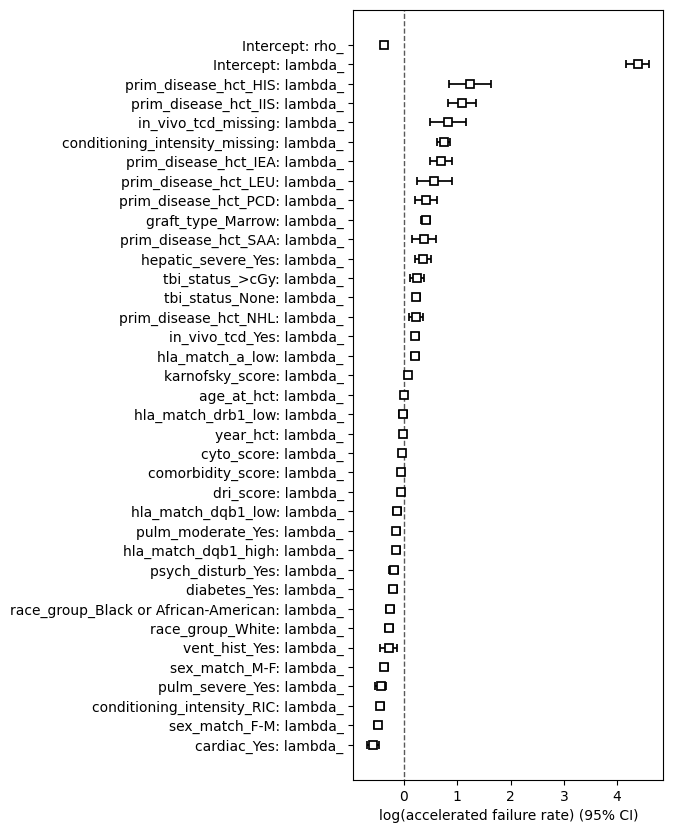

In [8]:
fig=plt.figure(figsize=[4,10])
waft_model.plot(figure=fig)
plt.show()

## 3. Survival forecasting

In [9]:
# Predict new survival function for training subjects
training_survival_functions=waft_model.predict_survival_function(training_significant_features_df)
training_expectations=waft_model.predict_expectation(training_significant_features_df)
training_survival_df=training_df[['efs', 'efs_time']].copy()
training_survival_df['Survival']=training_survival_functions.iloc[-1]
training_survival_df['Expectation']=training_expectations

# Predict new survival function for testing subjects
testing_survival_functions=waft_model.predict_survival_function(testing_significant_features_df)
testing_expectations=waft_model.predict_expectation(testing_significant_features_df)
testing_survival_df=testing_df[['efs', 'efs_time']].copy()
testing_survival_df['Survival']=testing_survival_functions.iloc[-1]
testing_survival_df['Expectation']=testing_expectations

training_survival_df.head()

,efs,efs_time,Survival,Expectation
0,1.0,2.142,0.063881,46.464758
1,0.0,105.944,0.099494,59.920349
2,0.0,34.787,0.268041,135.041976
3,1.0,6.964,0.013788,24.464473
4,1.0,5.541,0.146418,78.127198


### 3.1. Survival curves

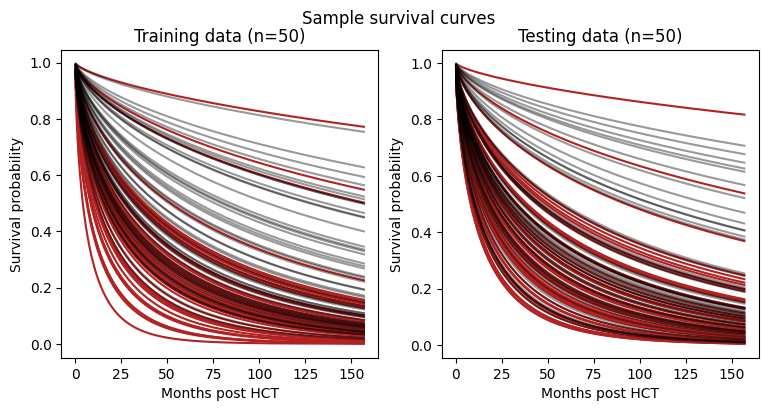

In [10]:
n_curves=50

# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

fig.suptitle('Sample survival curves')

efs_positive_ids=training_significant_features_df[training_significant_features_df['efs'] == 1].index
efs_negative_ids=training_significant_features_df[training_significant_features_df['efs'] == 0].index

efs_negative_survival_functions=training_survival_functions[efs_negative_ids]
efs_positive_survival_functions=training_survival_functions[efs_positive_ids]

axs[0].set_title(f'Training data (n={n_curves})')

for i in range(n_curves):
    axs[0].plot(efs_positive_survival_functions.index, efs_positive_survival_functions.iloc[:,i], color='firebrick', label='EFS 1')

for i in range(n_curves):
    axs[0].plot(efs_negative_survival_functions.index, efs_negative_survival_functions.iloc[:,i], color='black', alpha=0.4, label='EFS 0')

axs[0].set_xlabel('Months post HCT')
axs[0].set_ylabel('Survival probability')

efs_positive_ids=testing_significant_features_df[testing_significant_features_df['efs'] == 1].index
efs_negative_ids=testing_significant_features_df[testing_significant_features_df['efs'] == 0].index

efs_negative_survival_functions=testing_survival_functions[efs_negative_ids]
efs_positive_survival_functions=testing_survival_functions[efs_positive_ids]

axs[1].set_title(f'Testing data (n={n_curves})')

for i in range(n_curves):
    axs[1].plot(efs_positive_survival_functions.index, efs_positive_survival_functions.iloc[:,i], color='firebrick', label='EFS 1')

for i in range(n_curves):
    axs[1].plot(efs_negative_survival_functions.index, efs_negative_survival_functions.iloc[:,i], color='black', alpha=0.4, label='EFS 0')

axs[1].set_xlabel('Months post HCT')
axs[1].set_ylabel('Survival probability')

plt.show()

### 3.2. Survival probability at study end

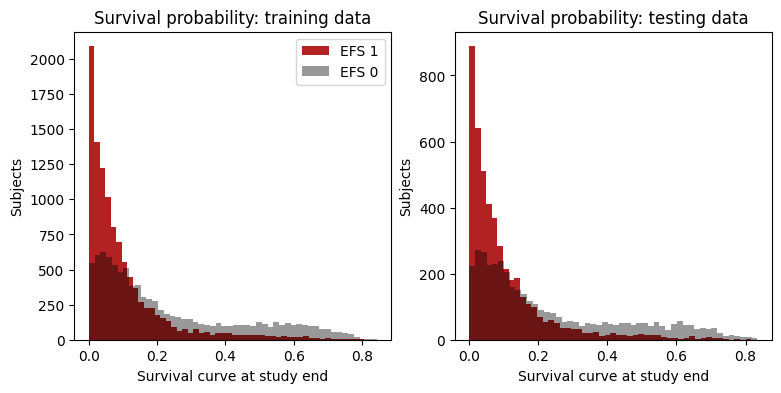

In [11]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

efs_positive_df=training_survival_df[training_survival_df['efs'] == 1]
efs_negative_df=training_survival_df[training_survival_df['efs'] == 0]

axs[0].set_title('Survival probability: training data')
axs[0].hist(efs_positive_df['Survival'], bins=50, color='firebrick', label='EFS 1')
axs[0].hist(efs_negative_df['Survival'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[0].set_xlabel('Survival curve at study end')
axs[0].set_ylabel('Subjects')
axs[0].legend(loc='best')

efs_positive_df=testing_survival_df[testing_survival_df['efs'] == 1]
efs_negative_df=testing_survival_df[testing_survival_df['efs'] == 0]

axs[1].set_title('Survival probability: testing data')
axs[1].hist(efs_positive_df['Survival'], bins=50, color='firebrick', label='EFS 1')
axs[1].hist(efs_negative_df['Survival'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[1].set_xlabel('Survival curve at study end')
axs[1].set_ylabel('Subjects')

plt.show()

### 3.3. Expectation value

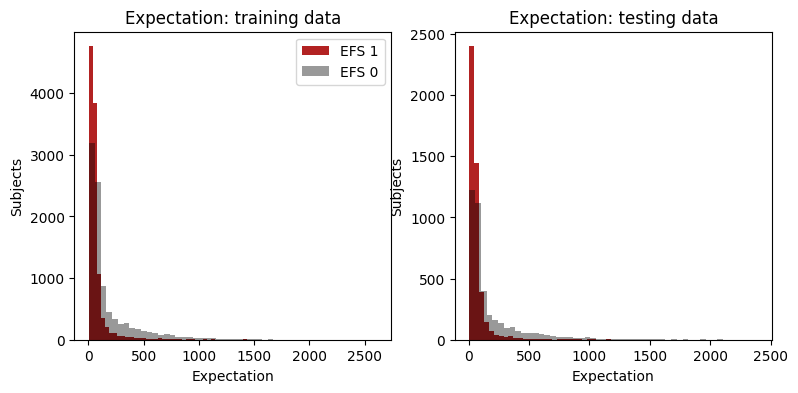

In [12]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

efs_positive_df=training_survival_df[training_survival_df['efs'] == 1]
efs_negative_df=training_survival_df[training_survival_df['efs'] == 0]

axs[0].set_title('Expectation: training data')
axs[0].hist(efs_positive_df['Expectation'], bins=50, color='firebrick', label='EFS 1')
axs[0].hist(efs_negative_df['Expectation'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[0].set_xlabel('Expectation')
axs[0].set_ylabel('Subjects')
axs[0].legend(loc='best')

efs_positive_df=testing_survival_df[testing_survival_df['efs'] == 1]
efs_negative_df=testing_survival_df[testing_survival_df['efs'] == 0]

axs[1].set_title('Expectation: testing data')
axs[1].hist(efs_positive_df['Expectation'], bins=50, color='firebrick', label='EFS 1')
axs[1].hist(efs_negative_df['Expectation'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[1].set_xlabel('Expectation')
axs[1].set_ylabel('Subjects')

plt.show()

### 3.4. C-index scoring

In [13]:
scoring_results=helper_funcs.score_predictions(
    'WeibullAFT survival',
    testing_survival_df['Survival'].values,
    testing_survival_df['efs_time'].values,
    testing_survival_df['efs'].values,
    data_dict['Testing race group'],
    data_dict['Testing IDs']
)

scoring_results=helper_funcs.score_predictions(
    'WeibullAFT',
    testing_survival_df['Expectation'].values,
    testing_survival_df['efs_time'].values,
    testing_survival_df['efs'].values,
    data_dict['Testing race group'],
    data_dict['Testing IDs'],
    results=scoring_results
)

scoring_results_df=pd.DataFrame(scoring_results)
scoring_results_df.head()

,Model,RMSE,C-index,Stratified C-index
0,WeibullAFT survival,33.530350,0.640559,0.622178
1,WeibullAFT,218.490269,0.640559,0.622178


## 4. Save survival features

In [14]:
waft_features={
    'Training survival': list(training_survival_df['Survival'].values),
    'Training expectation': list(training_survival_df['Expectation'].values),
    'Testing survival': list(testing_survival_df['Survival'].values),
    'Testing expectation': list(testing_survival_df['Survival'].values)
}

with open(survival_file, 'wb') as output_file:
    pickle.dump(waft_features, output_file)